In [1]:
import os

os.environ["AGENTQL_API_KEY"] = "WOqG4dMJImdIRUx2Hpsl-49ZKrsdkTkJwezdfcHpnXqUKeYpF5masA"

In [2]:
from langchain_agentql.document_loaders import AgentQLLoader

loader = AgentQLLoader(
    url="https://www.korea.kr/multi/visualNewsView.do?newsId=148942433",
    query="""
    {
        posts[] {
            content
            image
        }
    }
    """,
    is_scroll_to_bottom_enabled=True,
)

In [3]:
loader.load()

[Document(metadata={'request_id': '60916c57-88a2-4156-93dd-c1430f0e98b5', 'generated_query': None, 'screenshot': None}, page_content='{\'posts\': [{\'content\': \'학자금 의무상환 꿀팁 다 알려드립니다."어떻게 갚는게 나한테 나을까?"지금 고민하는 당신에게 딱 맞는 학자금 의무상환법!■ 미리납부 : 여유 있으면 미리 상환· 옵션① 의무상환액의 전액 납부· 옵션② 절반씩 납부(~5월/~11월)■ 원천공제 : 신경쓰기 싫으면 월급 공제매월 급여에서 자동 납부■ 상환유예 : 지금 어려우면 나중에 상환· 실직·퇴직·육아휴직 등 경제적 어려움을 겪고 있는 경우(2년)· 대학(원)에 재학 중인 경우(4년)새창으로 열림☞ 정책뉴스로 자세히보기\', \'image\': \'https://www.korea.kr/newsWeb/resources/attaches/2025.04/25/0425-2.jpg\'}, {\'content\': \'2025 청년정책 기사와 관련된더 자세한 내용은 아래에서 확인하세요.\', \'image\': None}]}')]

In [8]:
import requests
import base64
from IPython.display import Image, display

class MultiModal:
    def __init__(self, model, system_prompt=None, user_prompt=None):
        self.model = model
        self.system_prompt = system_prompt
        self.user_prompt = user_prompt
        self.init_prompt()

    def init_prompt(self):
        if self.system_prompt is None:
            self.system_prompt = "You are a helpful assistant on parsing images."
        if self.user_prompt is None:
            self.user_prompt = "Explain the given images in-depth."

    # 이미지를 base64로 인코딩하는 함수 (URL)
    def encode_image_from_url(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            image_content = response.content
            if url.lower().endswith((".jpg", ".jpeg")):
                mime_type = "image/jpeg"
            elif url.lower().endswith(".png"):
                mime_type = "image/png"
            else:
                mime_type = "image/unknown"
            return f"data:{mime_type};base64,{base64.b64encode(image_content).decode('utf-8')}"
        else:
            raise Exception("Failed to download image")

    # 이미지를 base64로 인코딩하는 함수 (파일)
    def encode_image_from_file(self, file_path):
        with open(file_path, "rb") as image_file:
            image_content = image_file.read()
            file_ext = os.path.splitext(file_path)[1].lower()
            if file_ext in [".jpg", ".jpeg"]:
                mime_type = "image/jpeg"
            elif file_ext == ".png":
                mime_type = "image/png"
            else:
                mime_type = "image/unknown"
            return f"data:{mime_type};base64,{base64.b64encode(image_content).decode('utf-8')}"

    # 이미지 경로에 따라 적절한 함수를 호출하는 함수
    def encode_image(self, image_path):
        if image_path.startswith("http://") or image_path.startswith("https://"):
            return self.encode_image_from_url(image_path)
        else:
            return self.encode_image_from_file(image_path)

    def display_image(self, encoded_image):
        display(Image(url=encoded_image))

    def create_messages(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        encoded_image = self.encode_image(image_url)
        if display_image:
            self.display_image(encoded_image)

        system_prompt = (
            system_prompt if system_prompt is not None else self.system_prompt
        )

        user_prompt = user_prompt if user_prompt is not None else self.user_prompt

        # 인코딩된 이미지를 사용하여 다른 처리를 수행할 수 있습니다.
        messages = [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"{encoded_image}"},
                    },
                ],
            },
        ]
        return messages

    def invoke(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        messages = self.create_messages(
            image_url, system_prompt, user_prompt, display_image
        )
        response = self.model.invoke(messages)
        return response.content

    def batch(
        self,
        image_urls: list[str],
        system_prompts: list[str] = [],
        user_prompts: list[str] = [],
        display_image=False,
    ):
        messages = []
        for image_url, system_prompt, user_prompt in zip(
            image_urls, system_prompts, user_prompts
        ):
            message = self.create_messages(
                image_url, system_prompt, user_prompt, display_image
            )
            messages.append(message)
        response = self.model.batch(messages)
        return [r.content for r in response]

    def stream(
        self, image_url, system_prompt=None, user_prompt=None, display_image=True
    ):
        messages = self.create_messages(
            image_url, system_prompt, user_prompt, display_image
        )
        response = self.model.stream(messages)
        return response

In [9]:
from langchain_core.messages import AIMessageChunk

def stream_response(response, return_output=False):
    """
    AI 모델로부터의 응답을 스트리밍하여 각 청크를 처리하면서 출력합니다.

    이 함수는 `response` 이터러블의 각 항목을 반복 처리합니다. 항목이 `AIMessageChunk`의 인스턴스인 경우,
    청크의 내용을 추출하여 출력합니다. 항목이 문자열인 경우, 문자열을 직접 출력합니다. 선택적으로, 함수는
    모든 응답 청크의 연결된 문자열을 반환할 수 있습니다.

    매개변수:
    - response (iterable): `AIMessageChunk` 객체 또는 문자열일 수 있는 응답 청크의 이터러블입니다.
    - return_output (bool, optional): True인 경우, 함수는 연결된 응답 문자열을 문자열로 반환합니다. 기본값은 False입니다.

    반환값:
    - str: `return_output`이 True인 경우, 연결된 응답 문자열입니다. 그렇지 않으면, 아무것도 반환되지 않습니다.
    """
    answer = ""
    for token in response:
        if isinstance(token, AIMessageChunk):
            answer += token.content
            print(token.content, end="", flush=True)
        elif isinstance(token, str):
            answer += token
            print(token, end="", flush=True)
    if return_output:
        return answer

In [10]:
from langchain_openai import ChatOpenAI

# 객체 생성
llm = ChatOpenAI(
    temperature=0.1,  # 창의성 (0.0 ~ 2.0)
    max_tokens=2048,  # 최대 토큰수
    model_name="gpt-4o",  # 모델명
)

# 멀티모달 객체 생성
multimodal_llm = MultiModal(llm)



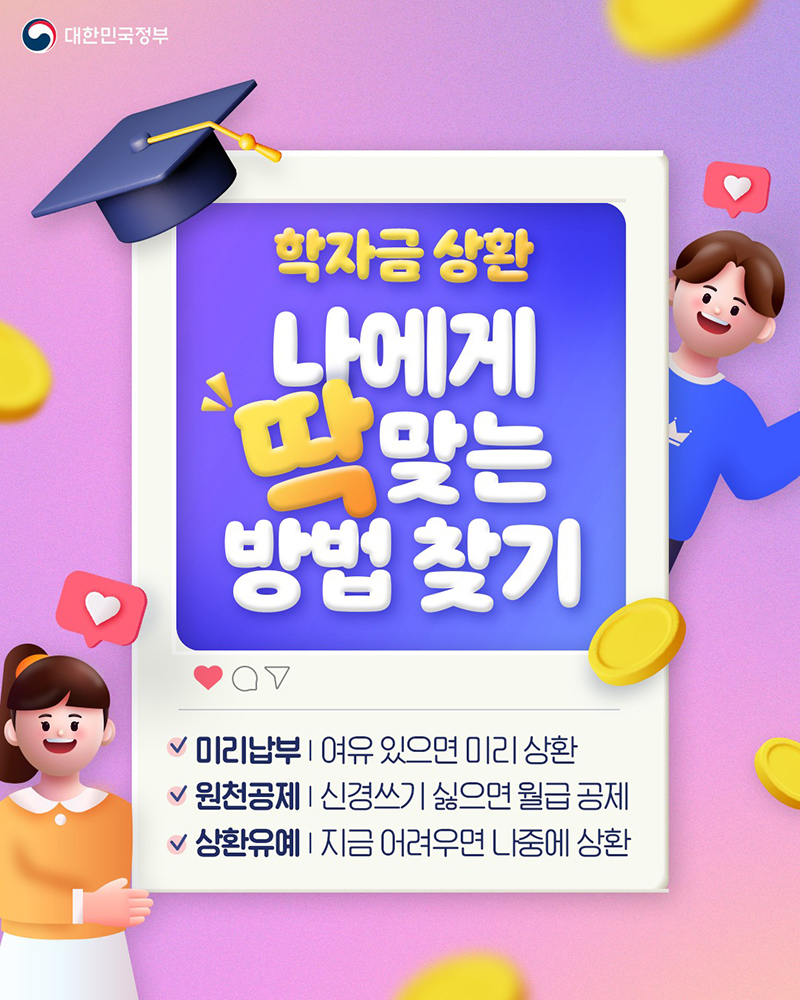

The image is a colorful and engaging infographic in Korean, likely aimed at students or young adults. It features a cartoonish design with vibrant colors and playful elements, such as coins and social media icons.

### Key Elements:

1. **Title and Main Message:**
   - The main text in the center reads: "학자금 상환 나에게 딱 맞는 방법 찾기," which translates to "Finding the Perfect Student Loan Repayment Method for Me."

2. **Visual Elements:**
   - A graduation cap is placed at the top, symbolizing education and student loans.
   - Cartoon characters are included, one on each side, adding a friendly and approachable feel.
   - Social media icons and a heart symbol suggest a connection to online platforms and engagement.

3. **Options for Loan Repayment:**
   - The text at the bottom lists three repayment options:
     - **미리납부 (Advance Payment):** If you have the means, pay in advance.
     - **원천공제 (Source Deduction):** If you dislike worrying about it, opt for monthly deductions.
     - **상환유예 (R

In [11]:
# 샘플 이미지 주소(웹사이트로 부터 바로 인식)
IMAGE_URL = 'https://www.korea.kr/newsWeb/resources/attaches/2025.04/25/0425-2.jpg'

# 이미지 파일로 부터 질의
answer = multimodal_llm.stream(IMAGE_URL)
# 스트리밍 방식으로 각 토큰을 출력합니다. (실시간 출력)
stream_response(answer)
